In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = '^IXIC'  # Nasdaq
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_nas.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(13474, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,4.605170,1.0,1.008400,1.008400
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,4.613535,1.0,0.999207,0.999207
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,4.612741,1.0,0.999305,0.999305
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,4.612047,1.0,1.007548,1.007548
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,4.619566,1.0,1.005914,1.005914
1971-02-12,102.050003,102.050003,102.050003,102.050003,102.050003,4.625463,1.0,1.001372,1.001372
1971-02-16,102.190002,102.190002,102.190002,102.190002,102.190002,4.626834,1.0,0.995596,0.995596
1971-02-17,101.739998,101.739998,101.739998,101.739998,101.739998,4.622421,1.0,0.996855,0.996855
1971-02-18,101.419998,101.419998,101.419998,101.419998,101.419998,4.619270,1.0,0.992901,0.992901


In [3]:
df.high[(df.high != df.low)]

Date
1984-10-11      244.699997
1984-10-12      246.199997
1984-10-15      247.699997
1984-10-16      247.899994
1984-10-17      247.100006
                  ...     
2024-07-08    18416.939453
2024-07-09    18511.890625
2024-07-10    18655.189453
2024-07-11    18671.070312
2024-07-12    18556.730469
Name: high, Length: 10015, dtype: float64

In [4]:
SIM_START = pd.to_datetime('1984-10-11')  # first day of legit open/close values
SIM_START

Timestamp('1984-10-11 00:00:00')

In [5]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'linear']), #'ma', 'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [6]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [7]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

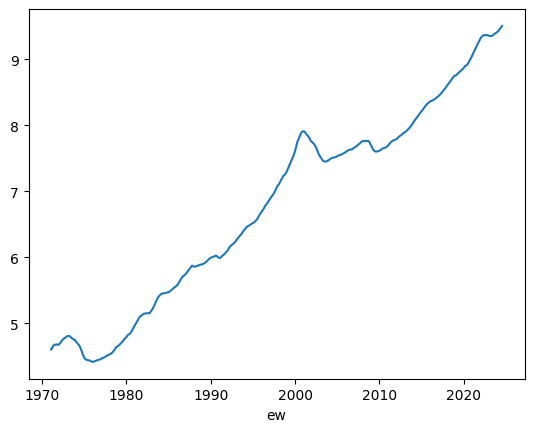

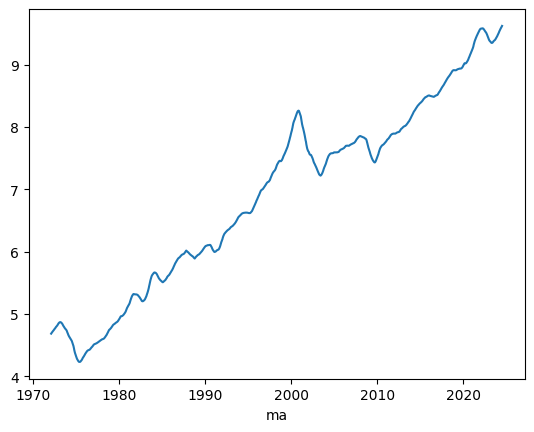

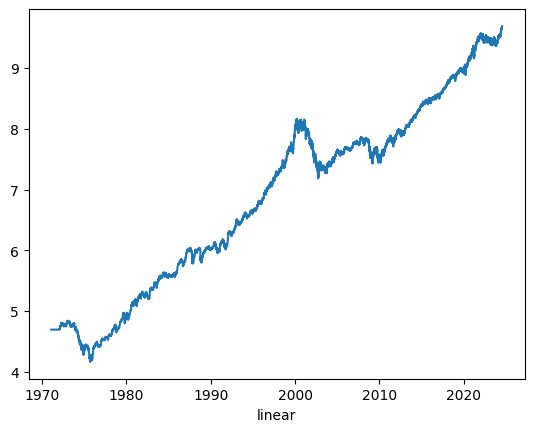

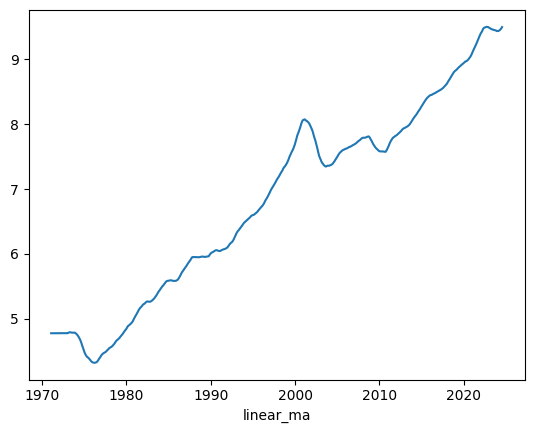

In [8]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [9]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [10]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [11]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [12]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [13]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [14]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(3063.9039969525234,
 {'time_param': 194,
  'method': 'linear',
  't': 0.6664299382396498,
  'k': 4.324173608530101,
  'as_q': False,
  'transform_f': 'bounded_curve'})

Do nothing res: 75.18777870128685
Round 1: 3063.9039969525234
New best: 3063.9039969525234
{'time_param': 194, 'method': 'linear', 't': 0.6664299382396498, 'k': 4.324173608530101, 'as_q': False, 'transform_f': 'bounded_curve'}


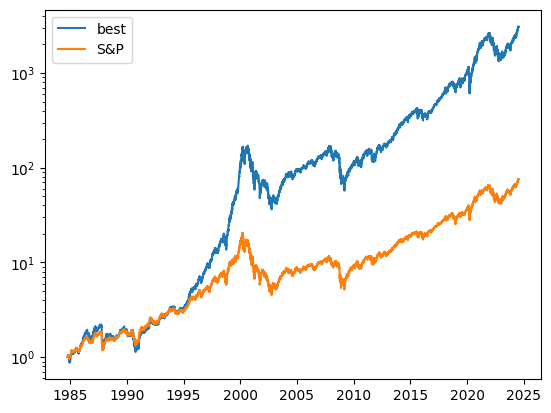

Round 2: 1.1666550806757676
Round 3: 75.48275334405437
Round 4: 23.41753865281867
Round 5: 2813.9454963931603
Round 6: 1.9521268146955864
Round 7: 371.4770376985441
Round 8: 4.849978789567889
Round 9: 1.8436411081343262
Round 10: 8.16089129951114
Round 11: 1.609400538961034
Round 12: 2120.4186014186503
Round 13: 1223.397955926907
Round 14: 19.027282068884766
Round 15: 101.59399569515412
Round 16: 1.2908762993984628
Round 17: 2611.7747112746692
Round 18: 84.05576216113064
Round 19: 5.004099583820578
Round 20: 1.9015877218141215
Round 21: 1335.379749964748
Round 22: 44.728535302427716
Round 23: 398.64407616807085
Round 24: 95.95211487734116
Round 25: 44.50964835228497
Round 26: 3856.328249022654
New best: 3856.328249022654
{'time_param': 59, 'method': 'ma', 't': 0.9124631550709046, 'k': 4.162566744277416, 'as_q': False, 'transform_f': 'bounded_curve'}


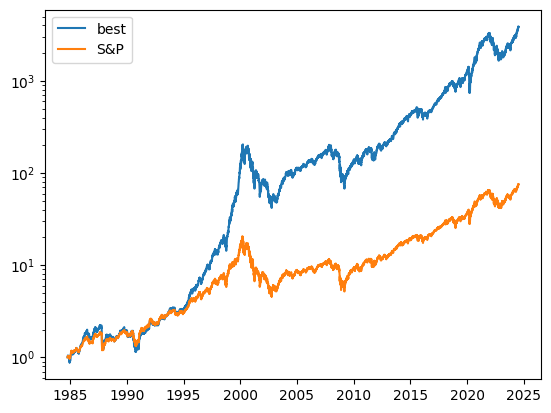

Round 27: 451.76045051237935
Round 28: 1.1415738358001808
Round 29: 3.3247376338191326
Round 30: 40.403955800080595
Round 31: 5.484394774870855
Round 32: 69.91836483767887
Round 33: 15.108592238628795
Round 34: 209.73125344367207
Round 35: 3463.1225395137626
Round 36: 1.5066232727074123
Round 37: 324.89000426494584
Round 38: 138.97827201196617
Round 39: 2.3846661483367506
Round 40: 58.269865422836915
Round 41: 269.89180588359585
Round 42: 42.49987280875524
Round 43: 2.464392453274998
Round 44: 1.3956113150400447
Round 45: 6.211893342192771
Round 46: 13.885794246033633
Round 47: 60.089225613150994
Round 48: 3.127344144191853
Round 49: 23.17085096417046
Round 50: 1.481036773763823
Round 51: 3676.5811085119403
Round 52: 53.017805369509205
Round 53: 34.95195207457786
Round 54: 463.1458604162159
Round 55: 2.95879668794056
Round 56: 162.22945767087364
Round 57: 497.31858531783365
Round 58: 8.385172966297402
Round 59: 33.510841455379186
Round 60: 1.56578650029513
Round 61: 236.01048404673705


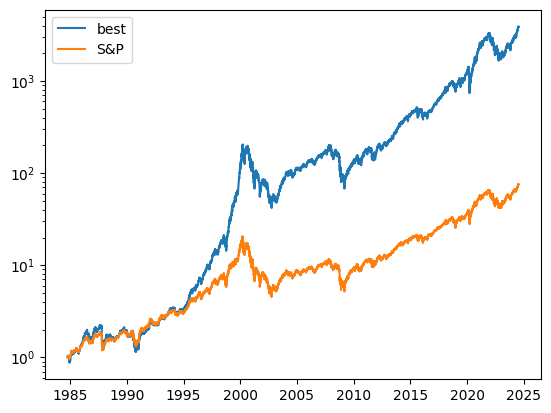

Round 87: 719.5137930294661
Round 88: 1.101235465556066
Round 89: 68.9640244100336
Round 90: 0.9204093774212416
Round 91: 1.4173461100521947
Round 92: 82.58043117044909
Round 93: 2.02720229939933
Round 94: 25.204215059026428
Round 95: 1.151684538581121
Round 96: 1.5345565428636223
Round 97: 1309.6268618409813
Round 98: 114.19416719777102
Round 99: 258.5879607696504
Round 100: 76.0561420096379


In [15]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 75.18777870128685
Round 1: 3868.6831342644273
New best: 3868.6831342644273
{'time_param': 18, 'method': 'linear_ma', 't': 0.999, 'k': 4.557207079597039, 'as_q': False, 'transform_f': 'bounded_curve'}


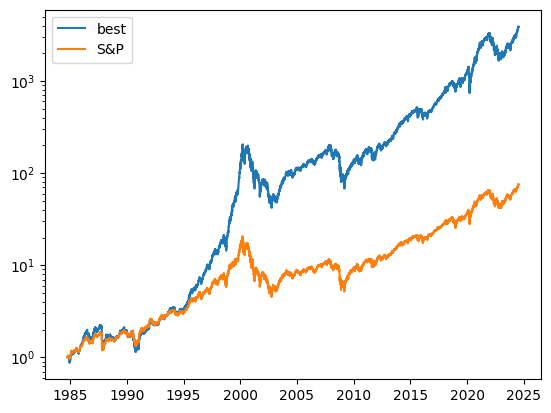

Round 2: 3868.6831342644273
Round 3: 1096.714132991824
Round 4: 3764.991382236016
Round 5: 3868.6831342644273
Round 6: 3868.6831342644273
Round 7: 3784.6025297904716
Round 8: 657.1485259237693
Round 9: 3868.6831342644273
Round 10: 3868.6831342644273
Round 11: 3860.590219756085
Round 12: 3868.7011200792494
New best: 3868.7011200792494
{'time_param': 17, 'method': 'linear_ma', 't': 0.9784786974169223, 'k': 4.683660143550919, 'as_q': False, 'transform_f': 'bounded_curve'}


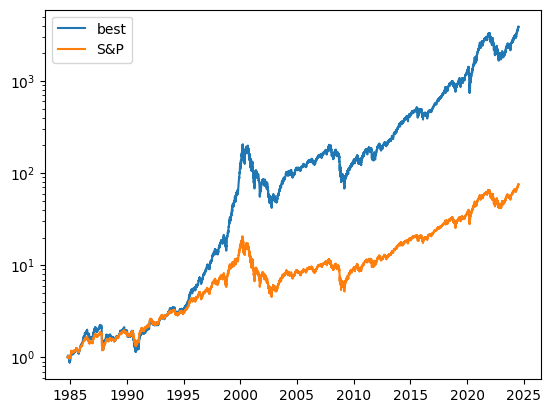

Round 13: 3868.6831342644273
Round 14: 2134.8074161406234
Round 15: 3868.6831342644273
Round 16: 3868.6831342644273
Round 17: 3868.6831342644273
Round 18: 3868.6831342644273
Round 19: 3868.6831342644273
Round 20: 3868.6831342644273
Round 21: 2.023377366414016
Round 22: 2075.445219992247
Round 23: 3869.998906169036
New best: 3869.998906169036
{'time_param': 15, 'method': 'linear_ma', 't': 0.9274913018211396, 'k': 4.558134534095993, 'as_q': False, 'transform_f': 'bounded_curve'}


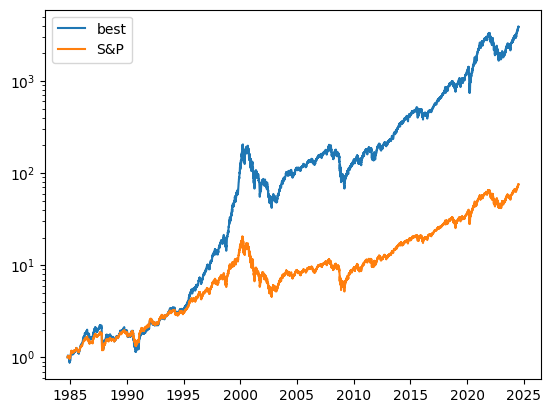

Round 24: 3875.250281103832
New best: 3875.250281103832
{'time_param': 14, 'method': 'linear_ma', 't': 0.9475682760620349, 'k': 4.300853496645358, 'as_q': False, 'transform_f': 'bounded_curve'}


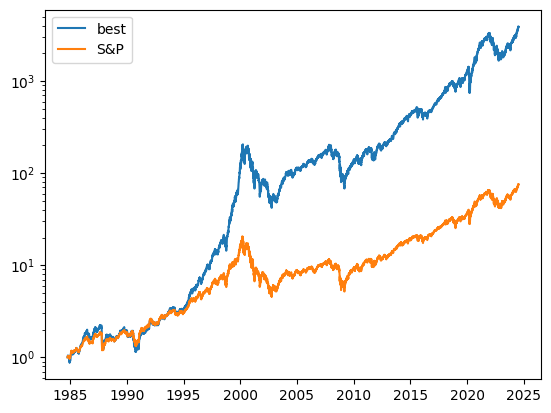

Round 25: 37.34618525243458

Factor: 1.03125
Do nothing res: 75.18777870128685
Round 1: 3868.6831342664063
Round 2: 3868.683134265908
Round 3: 3868.683134267676
Round 4: 679.9850821978405
Round 5: 3043.7361489606787
Round 6: 3868.6831342677524
Round 7: 2462.0117587453137
Round 8: 2902.271468617711
Round 9: 329.840418476727
Round 10: 3868.683134265908
Round 11: 544.4676245187695
Round 12: 3868.6831342658766
Round 13: 3868.683134267679
Round 14: 3868.6831342684522
Round 15: 3868.6831342659593
Round 16: 3868.6831342682053
Round 17: 796.1822819778333
Round 18: 3928.0250619647636
New best: 3928.0250619647636
{'time_param': 13, 'method': 'linear_ma', 't': 0.886058924060999, 'k': 4.3079167897820945, 'as_q': False, 'transform_f': 'bounded_curve'}


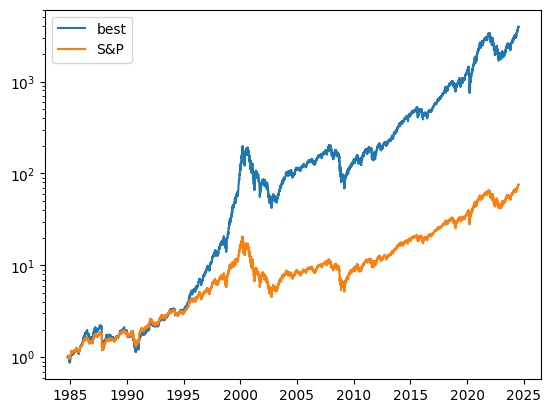

Round 19: 3970.0268954692183
New best: 3970.0268954692183
{'time_param': 12, 'method': 'linear_ma', 't': 0.9709181046955669, 'k': 4.431416126443564, 'as_q': False, 'transform_f': 'bounded_curve'}


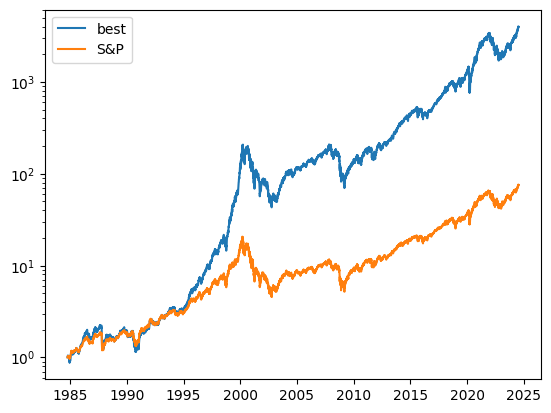

Round 20: 3870.929974617661
Round 21: 3870.4906247053054
Round 22: 3885.77701565338
Round 23: 3870.4725353011368
Round 24: 3870.792822485198
Round 25: 4017.199413958
New best: 4017.199413958
{'time_param': 11, 'method': 'linear_ma', 't': 0.9215360063567908, 'k': 4.345894943202241, 'as_q': False, 'transform_f': 'bounded_curve'}


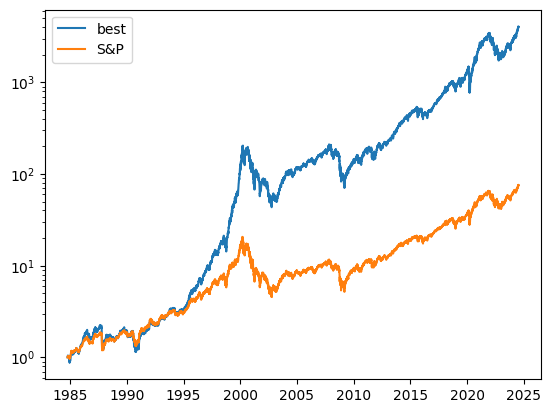


Factor: 1.015625
Do nothing res: 75.18777870128685
Round 1: 3868.6831342938376
Round 2: 3868.6831343017457
Round 3: 3868.6831343124004
Round 4: 3868.6831343142003
Round 5: 1749.3100494867017
Round 6: 1687.0811973718637
Round 7: 3868.683134312048
Round 8: 3868.683134293687
Round 9: 3541.432889852933
Round 10: 3868.683134292241
Round 11: 3931.121895495461
Round 12: 628.6937439598303
Round 13: 2585.3723296603025
Round 14: 3868.6831343063186
Round 15: 4006.5507004333003
Round 16: 165.48137365948463
Round 17: 3868.6831343047043
Round 18: 3811.732323148486
Round 19: 30.51790085859064
Round 20: 309.00508551177074
Round 21: 3868.683134303808
Round 22: 31.128574782472384
Round 23: 3938.7917636211014
Round 24: 3868.683134296978
Round 25: 3868.6831342942924

Factor: 1.0078125
Do nothing res: 75.18777870128685
Round 1: 3868.683134296657
Round 2: 3868.683134300067
Round 3: 3920.5794203245114
Round 4: 2733.5973477078533
Round 5: 3868.6831343068257
Round 6: 2127.669452007496
Round 7: 3868.6831343034

In [16]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [42]:
# Force set:
#best_out = 3063.9039969525234
#params_out = {'time_param': 194, 'method': 'linear', 't': 0.6664299382396498, 'k': 4.324173608530101, 'as_q': False, 'transform_f': 'bounded_curve'}

In [43]:
final_out = simulate(df, params_out)

In [44]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9612541279500277

In [45]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.6439492987344508

In [46]:
params_out

{'time_param': 194,
 'method': 'linear',
 't': 0.6664299382396498,
 'k': 4.324173608530101,
 'as_q': False,
 'transform_f': 'bounded_curve'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


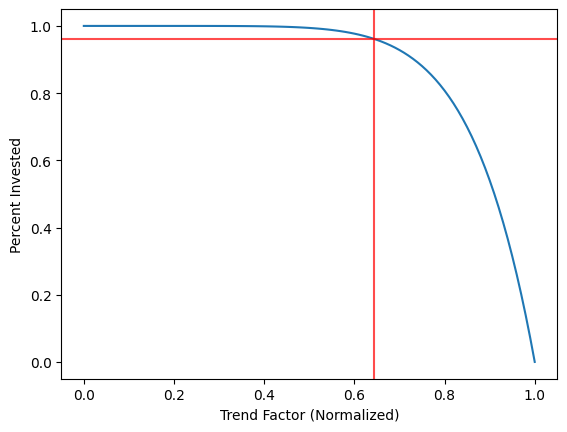

In [47]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

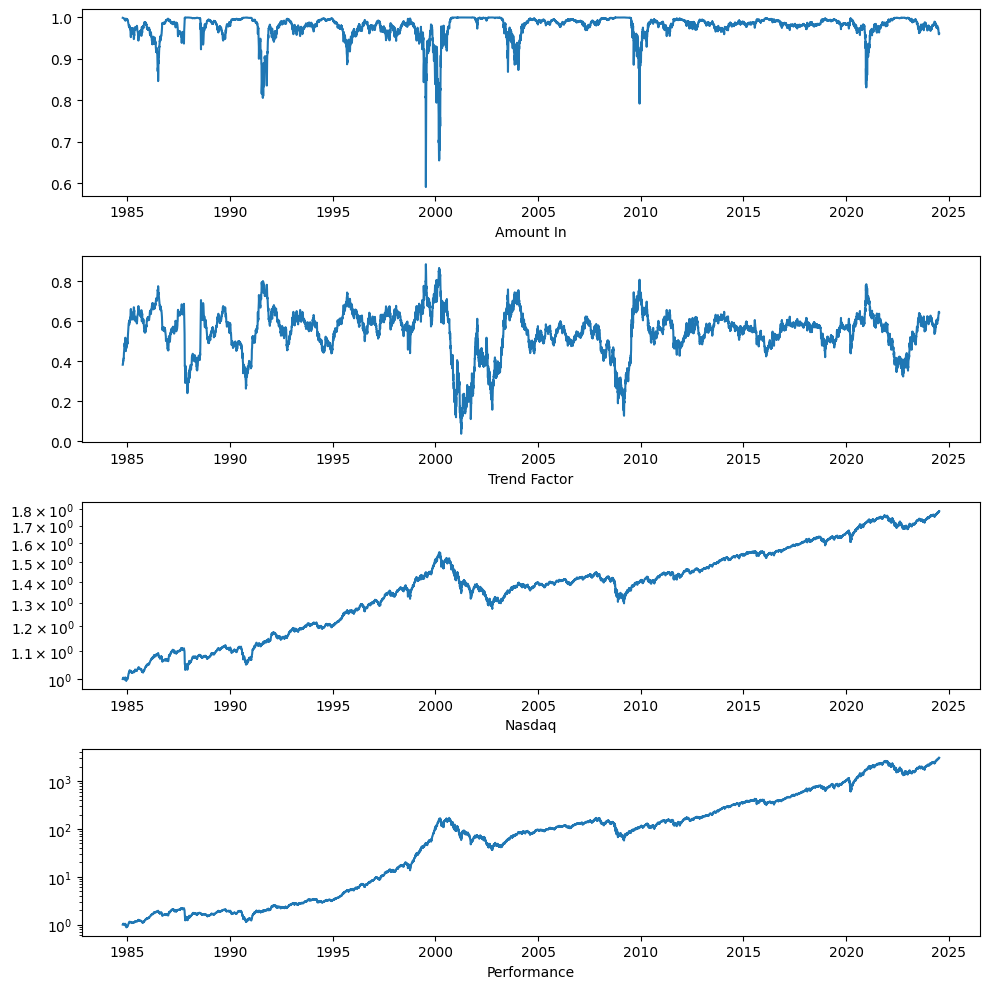

In [48]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('Nasdaq')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [49]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Nasdaq')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

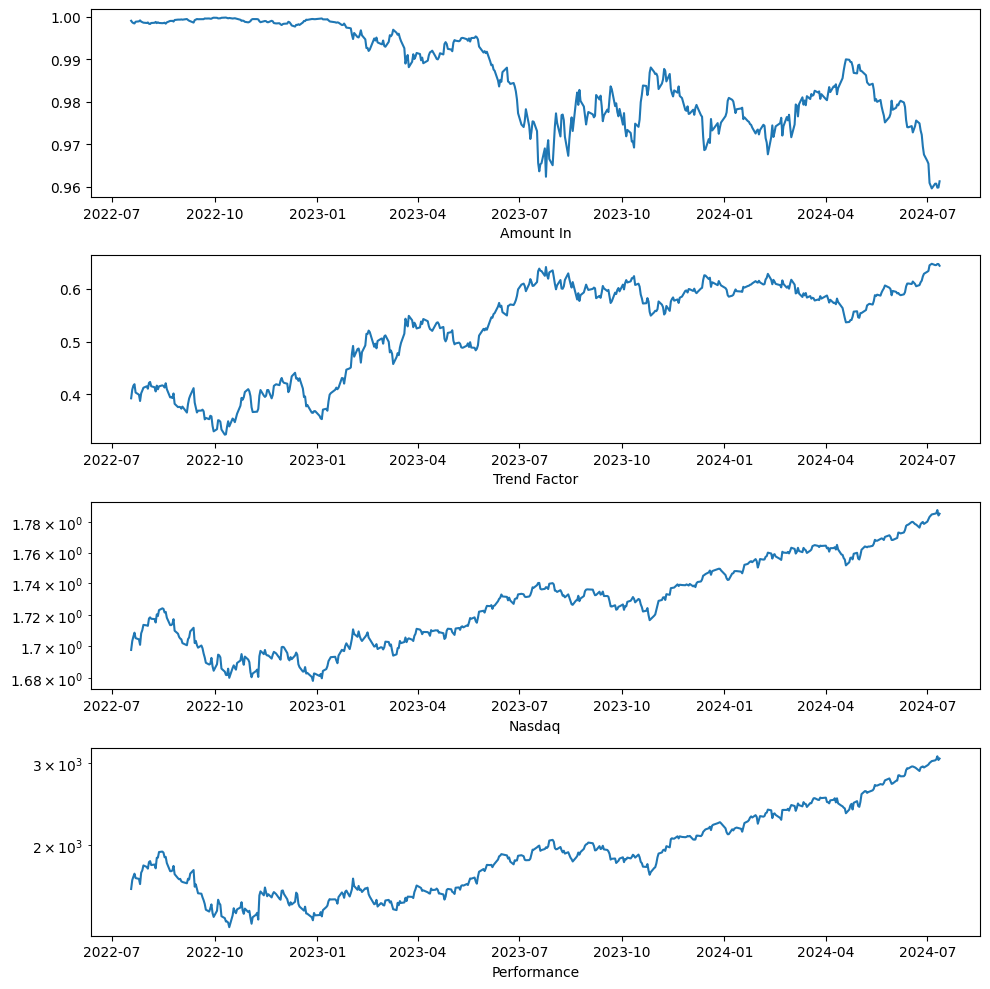

In [50]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('Nasdaq')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [51]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(3063.9039969525234,
 {'time_param': 194,
  'method': 'linear',
  't': 0.6664299382396498,
  'k': 4.324173608530101,
  'as_q': False,
  'transform_f': 'bounded_curve'})

In [52]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.9613

In [53]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(244.6999969482422, 40.068, 18398.44921875)

In [54]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.2218248776758529

In [55]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['nas'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.117876849072677, 0.9707], 'nas': [1.221824877675853, 0.9613], 'rus': [1.179140086085579, 0.7011], 'jpxn': [1.040675132153293, 0.4608], 'ktec': [1.6341335437597972, 0.0], 'emb': [1.0930267669763505, 0.9993], 'gdx': [1.3540718780854035, 0.0043]}
